# Runs numerics for mean field model and numerics in finite state space continuous time Markov chain with N listings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import csv
import time
import itertools
from numpy import random
from operator import itemgetter
import importlib
import multiprocessing as mp
import json

In [2]:
import experiment_helper
import exp_wrapper 

import finite_sim as sim
import finite_sim_wrapper as sim_wrapper

In [3]:
importlib.reload(exp_wrapper)
importlib.reload(experiment_helper)
importlib.reload(sim)
importlib.reload(sim_wrapper)

<module 'finite_sim_wrapper' from '/home/jhays/herding-bias/finite_sim_wrapper.py'>

# Setting parameters model parameters

In [4]:
alpha = 1
epsilon = 1
tau = 1
lams = [ .1, 1, 10]


tsr_ac_al_values = [.5]
cr_a_C = 0.5
lr_a_L = 0.5

tsr_est_types = ['tsr_est_naive', 'tsri_1.0','tsri_2.0']


In [5]:
customer_types = ['c1']
listing_types = ['l']
exp_conditions = ['control', 'treat']
rhos_pre_treat = {'l':1} #adds up to 1
customer_proportions = {'c1':1} #adds up to 1

# used for multiplicative utilities
customer_type_base = {'c1':.315 }
listing_type_base = {'l':1}
exp_condition_base = {'control':1, 'treat':1.25}

vs = {}
#multiplicative -- default
for c in customer_types:
    vs[c] = {}
    vs[c]['treat'] = {}   
    vs[c]['control'] = {}
    for l in listing_types:
        for e in exp_conditions:
            vs[c][e][l] = round(customer_type_base[c]
                                *exp_condition_base[e]
                                *listing_type_base[l],4)

for c in customer_types:
    print("customer", c)
    print("control", vs[c]['control'])
    print("treatment", vs[c]['treat'], "\n")
print('Rhos:', rhos_pre_treat)
print("Customer Proportions:", customer_proportions)

customer c1
control {'l': 0.315}
treatment {'l': 0.3937} 

Rhos: {'l': 1}
Customer Proportions: {'c1': 1}


# Mean Field performance


Calculates the GTE and estimates in the mean field setting.  Solves for the mean field steady state in each experiment setting, along with global treatment and global control settings. 

In [6]:
tsr_bias_mf = {}
lr_bias_mf = {}
cr_bias_mf = {}
global_control_booking_probs_mf = {}
global_treat_booking_probs_mf = {}
gc_occupancy = {}
gtes = {}
gtes_norm = {}

global_solutions = {}
lr_solutions = {}
cr_solutions = {}
tsr_solutions = {}
tsr_fixed_solutions = {}

tsr_full_results = {}
tsr_fixed_full_results = {}

lr_params = {}
cr_params = {}
tsr_params = {}
tsr_fixed_params = {}

a_Cs = {}
a_Ls = {}
betas = {}
scales = {}
cr_side_weights = {}

tsr_fixed_customer_comp = {}
tsr_fixed_listing_comp = {}

norm_constants = {}
# normalize estimates and booking rates by min(lam, tau) to control for size of market
for lam in lams:
    norm_constants[lam] = 1 / min(lam, tau)

for lam in lams:
    betas[lam] =  np.exp(-1*lam/tau)
    cr_side_weights[lam] = np.exp(-lam/tau)
    a_Cs[lam] = 1/2 * betas[lam] + 1*(1-betas[lam])
    a_Ls[lam] = 1 * betas[lam] + 1/2 * (1-betas[lam])
    scales[lam] = betas[lam]*(1-betas[lam]) #how to scale competition terms


In [7]:
for lam in lams:
    tsr_param = exp_wrapper.tsr_exp_induced_parameters(listing_types, rhos_pre_treat, 
                                                     a_Cs[lam], a_Ls[lam], 
                                                      customer_types, customer_proportions, 
                                                       alpha, vs, lam)
    global_solution = exp_wrapper.calc_gte_from_exp_type("tsr", tau, epsilon, 
                                                         **tsr_param) 
    global_solutions[lam] = global_solution
    gtes[lam] = global_solution['gte']
    gtes_norm[lam] = global_solution['gte']*norm_constants[lam]
    
    tsr_results = exp_wrapper.run_experiment("tsr", epsilon, tau, **tsr_param,
                                             a_C=a_Cs[lam],  a_L=a_Ls[lam], 
                                            customer_side_weight=cr_side_weights[lam],
                                             scale=scales[lam]
                                            )
    
    tsr_bias_mf[lam]={}
    for tsr_est in tsr_est_types:
        tsr_bias_mf[lam][tsr_est]= ((tsr_results['estimator'][tsr_est] - gtes[lam])
                                    *norm_constants[lam])

    lr_exp_param = exp_wrapper.listing_side_exp_induced_parameters(listing_types, rhos_pre_treat, lr_a_L,
                                                                customer_types, 
                                                                  alpha, vs, lam, customer_proportions)
    lr_sol = exp_wrapper.run_experiment("listing", epsilon, tau,**lr_exp_param, a_L=lr_a_L)
    lr_bias_mf[lam] = abs(lr_sol['estimator']['naive_est'] - gtes[lam])*norm_constants[lam]

    
    cr_exp_param = exp_wrapper.customer_side_exp_induced_parameters(listing_types, rhos_pre_treat, cr_a_C, 
                                                    customer_types, alpha, vs, lam, customer_proportions)
    cr_sol = exp_wrapper.run_experiment("customer",epsilon, tau, **cr_exp_param, a_C=cr_a_C)
    cr_bias_mf[lam] = abs(cr_sol['estimator']['naive_est'] - gtes[lam])*norm_constants[lam]

    

In [8]:

mf_bias_df = pd.DataFrame([cr_bias_mf, lr_bias_mf]
                     + [{lam:tsr_bias_mf[lam][tsr_est] for lam in lams} 
                        for tsr_est in tsr_est_types],
                        index=['cr', 'lr'] +tsr_est_types)
mf_bias_df = pd.DataFrame(mf_bias_df.stack())
mf_bias_df.index.names = ['estimator_type', 'lambda']
mf_bias_df = mf_bias_df.rename(columns={0:'bias'})
mf_bias_df['dummy'] = 1

### Comparing Estimators in mean field

In [12]:
rgb_dict = {'cr': (0, 114, 178), 'lr':(255, 127, 14),
          'tsrn':(0, 158, 115), 'tsri1':(240, 228, 66), 
            'tsri2':(204, 121, 167),
          'cluster':(86, 180, 233)}

rgb_0_1_array = np.array(list(rgb_dict.values()))/255


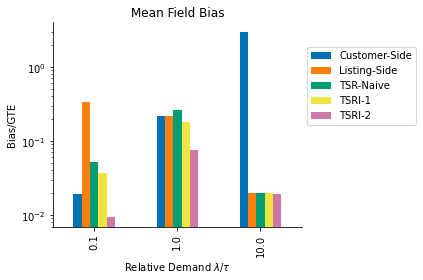

In [10]:
ax = plt.figure().add_subplot(111)
df = ((mf_bias_df
         .rename({'tsr_est_gw':'Two-Sided', 'cr':"Customer-Side", 'lr':"Listing-Side",
                 'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                 'tsr_est_naive':"TSR-Naive"}, 
                 level=0)
         .unstack(level=1)['bias']/gtes_norm)
         .abs()
         .reindex(["Customer-Side", "Listing-Side", 
                   "TSR-Naive",
                   'TSRI-1',
                   'TSRI-2'])
        ).T


df.plot(ax=ax, kind='bar', color=rgb_0_1_array)
plt.xlabel("Relative Demand $\lambda/\\tau$")
plt.yscale('log')
plt.legend(loc=[1.02,0.5])


plt.title("Mean Field Bias")
plt.ylabel("Bias/GTE")
plt.tight_layout()
sns.despine()


# Simulations

Setting simulation parameters. Remaining model parameters as defined in mean field parameters.

In [9]:
T_0 = 5
T_1 = 25

# normalizes time horizon by min(lam, tau)
T_start = {lam: T_0/min(lam,tau) for lam in lams}
T_end = {lam: T_1/min(lam,tau) for lam in lams}

varying_time_horizons = True

n_runs = 100
n_listings = 100

Define choice set type. If 'alpha', customers sample items into consideration set with prob alpha. If 'finite_k', each customer draws a fixed $k$ number of items into their consideration set.

In [10]:
choice_set_type = 'alpha' #customers sample items into consideration set with prob alpha
k = None

In [11]:
params = sim_wrapper.calc_all_params(listing_types, rhos_pre_treat, 
                                     customer_types, customer_proportions, vs, 
                                    alpha, epsilon, tau, lams,
                                    tsr_ac_al_values, cr_a_C, lr_a_L)

## Herding

In [12]:
events_herding = sim_wrapper.run_all_sims(n_runs, n_listings, T_start, T_end, 
                                  choice_set_type, k,
                                 alpha, epsilon, tau, lams,
                                 **params, herding=True)
est_stats_herding = sim_wrapper.calc_all_ests_stats("sample", T_start, T_end, 
                                            n_listings, tau=tau, 
                                            tsr_est_types=tsr_est_types,
                                            events=events_herding, 
                                            varying_time_horizons=varying_time_horizons,
                                            **params
                                           )

lambda= 0.1
Time elapsed:  342.95
lambda= 1
Time elapsed:  298.57
lambda= 10
Time elapsed:  1510.37


In [13]:
est_stats_herding = est_stats_herding.rename({'cr':"Customer-Side", 'lr':"Service-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

## Competition

In [14]:
events_competition = sim_wrapper.run_all_sims(n_runs, n_listings, T_start, T_end, 
                                  choice_set_type, k,
                                 alpha, epsilon, tau, lams,
                                 **params)
est_stats_competition = sim_wrapper.calc_all_ests_stats("sample", T_start, T_end, 
                                            n_listings, tau=tau, 
                                            tsr_est_types=tsr_est_types,
                                            events=events_competition, 
                                            varying_time_horizons=varying_time_horizons,
                                            **params
                                           )

lambda= 0.1
Time elapsed:  370.3
lambda= 1
Time elapsed:  320.93
lambda= 10
Time elapsed:  1542.52


In [15]:
est_stats_competition = est_stats_competition.rename({'cr':"Customer-Side", 'lr':"Service-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

## Visualizations: Herding

In [16]:
rgb_dict = {'cr': (0, 114, 178), 'lr':(255, 127, 14),
          'tsrn':(0, 158, 115), 'tsri1':(240, 228, 66), 
            'tsri2':(204, 121, 167),
          'cluster':(86, 180, 233)}

rgb_0_1_array = np.array(list(rgb_dict.values()))/255

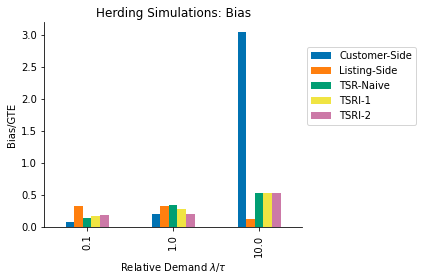

In [35]:
stat = 'bias_over_GTE'

(est_stats_herding
 .unstack(level=0)[stat]
 .plot(kind='bar', color=rgb_0_1_array))

#plt.yscale('log')
plt.title("Herding Simulations: Bias")
plt.legend(loc=[1.02,0.5])
plt.ylabel("Bias/GTE")
plt.xlabel("Relative Demand $\lambda/\\tau$")
plt.tight_layout()
sns.despine()
plt.savefig("herding_bias.svg")

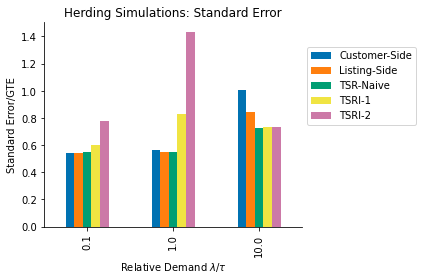

In [21]:
stat = 'std_over_GTE'

(est_stats_herding
 .unstack(level=0)[stat]
 .plot(kind='bar',color=rgb_0_1_array))


plt.xlabel("Relative Demand $\lambda/\\tau$")
plt.title("Herding Simulations: Standard Error")
plt.legend(loc=[1.02,0.5])
plt.ylabel("Standard Error/GTE")
plt.tight_layout()
sns.despine()


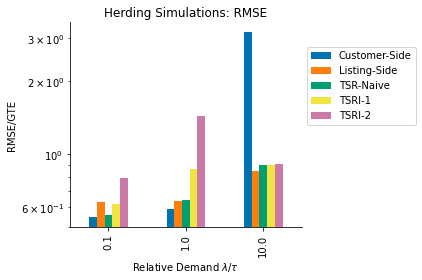

In [22]:
stat = 'rmse_over_GTE'

(est_stats_herding
 .unstack(level=0)[stat]
 .plot(kind='bar', color=rgb_0_1_array))


plt.yscale('log')
plt.xlabel("Relative Demand $\lambda/\\tau$")
plt.title("Herding Simulations: RMSE")
plt.legend(loc=[1.02,0.5])
plt.ylabel("RMSE/GTE")
plt.tight_layout()
sns.despine()

## Visualizations: competition

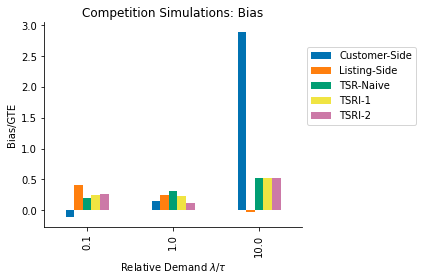

In [34]:
stat = 'bias_over_GTE'

(est_stats_competition
 .unstack(level=0)[stat]
 .plot(kind='bar', color=rgb_0_1_array))

#plt.yscale('log')
plt.xlabel("Relative Demand $\lambda/\\tau$")
plt.title("Competition Simulations: Bias")
plt.legend(loc=[1.02,0.5])
plt.ylabel("Bias/GTE")
plt.tight_layout()
sns.despine()
plt.savefig("competition_bias.svg")

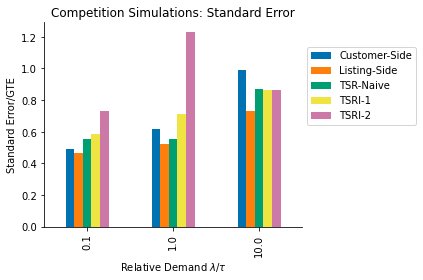

In [25]:
stat = 'std_over_GTE'

(est_stats_competition
 .unstack(level=0)[stat]
 .plot(kind='bar',color=rgb_0_1_array))


plt.xlabel("Relative Demand $\lambda/\\tau$")
plt.title("Competition Simulations: Standard Error")
plt.legend(loc=[1.02,0.5])
plt.ylabel("Standard Error/GTE")
plt.tight_layout()
sns.despine()


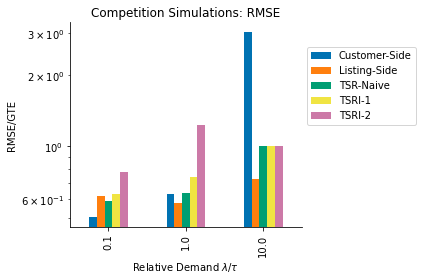

In [26]:
stat = 'rmse_over_GTE'

(est_stats_competition
 .unstack(level=0)[stat]
 .plot(kind='bar', color=rgb_0_1_array))


plt.yscale('log')
plt.xlabel("Relative Demand $\lambda/\\tau$")
plt.title("Competition Simulations: RMSE")
plt.legend(loc=[1.02,0.5])
plt.ylabel("RMSE/GTE")
plt.tight_layout()
sns.despine()